<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [130]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

import squarify

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read thru the documentation to accomplish this task. 

`Tip:` You will need to install the `bs4` library inside your conda environment. 

In [102]:
from bs4 import BeautifulSoup
import requests

##### Your Code Here #####
listings = pd.read_csv('./data/job_listings.csv', usecols=['title','description'])
listings['parsed_description'] = listings['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
listings['cleaned_description'] = listings['parsed_description'].apply(lambda x: re.sub(r'\\(x|n|b)[a-z0-9]{0,2}', ' ', x))
listings['cleaned_description'] = listings['cleaned_description'].apply(lambda x: x.lower())
listings['cleaned_description'] = listings['cleaned_description'].apply(lambda x: re.sub(r'b"', ' ', x))
listings['cleaned_description'] = listings['cleaned_description'].apply(lambda x: re.sub(r"b'", ' ', x))
listings['cleaned_description'] = listings['cleaned_description'].apply(lambda x: re.sub(r'\\{0,2}', '', x))

listings.head()

,description,title,parsed_description,cleaned_description
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ...",job requirements: conceptual understanding in...
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","job description as a data scientist 1, you w..."
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,as a data scientist you will be working on co...
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","$4,969 - $6,756 a monthcontractunder the gene..."
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,location: usa multiple locations + years ...


In [103]:
listings['cleaned_description'][0]

' job requirements: conceptual understanding in machine learning models like nai  ve bayes, k-means, svm, apriori, linear/ logistic regression, neural, random forests, decision trees, k-nn along with hands-on experience in at least 2 of them intermediate to expert level coding skills in python/r. (ability to write functions, clean and efficient data manipulation are mandatory for this role) exposure to packages like numpy, scipy, pandas, matplotlib etc in python or ggplot2, dplyr, tidyr in r ability to communicate model findings to both technical and non-technical stake holders hands on experience in sql/hive or similar programming language must show past work via github, kaggle or any other published article master\'s degree in statistics/mathematics/computer science or any other quant specific field. apply now"'

## 2) Use Spacy to tokenize the listings 

In [124]:
##### Your Code Here #####
nlp = spacy.load('en_core_web_lg')

def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.text != ' ')]

In [125]:
listings['tokens'] = listings['cleaned_description'].apply(tokenize)

In [126]:
listings['cleaned_description'].head()

0     job requirements: conceptual understanding in...
1     job description  as a data scientist 1, you w...
2     as a data scientist you will be working on co...
3     $4,969 - $6,756 a monthcontractunder the gene...
4     location: usa     multiple locations + years ...
Name: cleaned_description, dtype: object

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [127]:
##### Your Code Here #####
BoW = CountVectorizer(tokenizer=tokenize, ngram_range=[1,1])

counts = BoW.fit_transform(listings['cleaned_description'])

In [138]:
dtm = pd.DataFrame(counts.todense(), columns=BoW.get_feature_names())

wc = dtm.sum().sort_values(ascending=False)
wc.head(20)

datum          3396
experience     1937
               1839
work           1650
team           1372
business       1263
data           1062
science         989
product         893
analytic        842
model           822
analysis        811
learning        763
skill           722
machine         710
scientist       705
build           632
develop         623
opportunity     582
solution        580
dtype: int64

## 4) Visualize the most common word counts

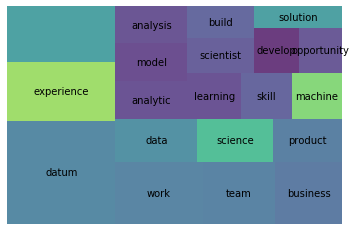

In [139]:
##### Your Code Here #####


squarify.plot(sizes=wc.tolist()[:20], label=wc.index.tolist()[:20], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [141]:
##### Your Code Here #####

# Instantiate vectorizer object
tfidf = TfidfVectorizer(tokenizer=tokenize, ngram_range=[1,1])

dtm = tfidf.fit_transform(listings['cleaned_description'])

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,,$,+,+2,+3,-10,-2,-3,-4,-5,...,zogsport,zone,zoom,zuckerberg,zurich,|,||,~$70,~1,~4
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.133396,0.000000,0.027459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.212764,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.092113,0.000000,0.151687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [142]:
##### Your Code Here #####

from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [172]:
ideal_job = '''eleventy million dollars a year just for knowing what spectral decomposition means'''
query = tfidf.transform([ideal_job])

In [173]:
nn.kneighbors(query.todense())

(array([[1.35699823, 1.36220342, 1.36220342, 1.36714854, 1.37478998]]),
 array([[111,  23, 123, 115, 186]], dtype=int64))

In [169]:
listings.iloc[111]['cleaned_description']

' mine rich user data sets and find insights that will drive the decisions that power our platform.  ----------- the mission -----------  agogo is on a mission to revolutionize the way people get tickets to live events, making it possible for anyone, anywhere in the world to see their favorite artists, teams or shows live. we\'ve helped millions of people from almost every country attend live events, and we\'re just getting started. we believe creative individuals with innovative ideas are the engine for our rapid growth, so we\'re looking for the world\'s smartest data scientists to join our team, where you\'ll be given the freedom to make meaningful and measurable improvements impacting millions of people.  --------- your role ---------  data scientists sit at the core of our business, constantly working to identify new product features and improvements that enhance the experience for our users and drive pro   table revenue streams for the company. you\'ll be part of a team using dat

In [176]:
# goofing off

ideal_job = '''eleventy million dollars a year just for knowing what spectral decomposition means'''
potato = '''potato'''

embed_ideal_job = nlp(ideal_job)
embed_potato = nlp(potato)

similarity = embed_ideal_job.similarity(embed_potato)
print(similarity)


0.25298779498795


## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 